# Project 2: Mini deep-learning framework

In [2]:
import matplotlib.pyplot as plt #To remove (use matplotlib)
from torch import empty
import numpy as np
import math
import torch.nn as nn

from torch.autograd import Variable
from torch.nn import functional as F
import torch
torch.set_grad_enabled(False)

## Data generation

tensor([[1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.]])
Sanity check:  tensor(1000.)  /  1000
Sanity check:  tensor(1000.)  /  1000


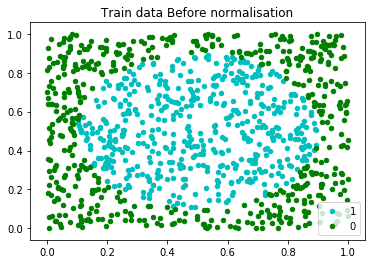

Point outside:  507
Point inside:   493


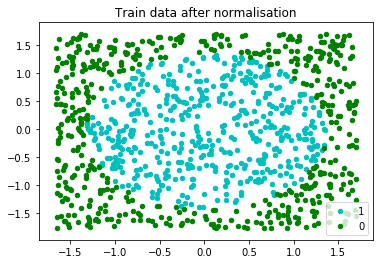

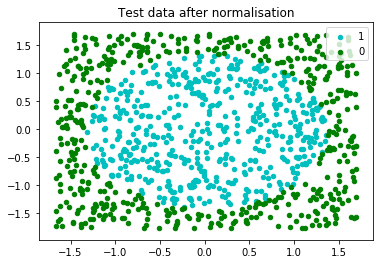

In [3]:
def generate_disc_set(nb):
    X = empty(nb,2).uniform_(0,1)
    Y = empty(X.size())
    Y[:,0] = ( (X - 0.5).norm(dim=1)  >  math.sqrt(1/(2*math.pi)) ).type(torch.LongTensor)
    Y[:,1] = ( (X - 0.5).norm(dim=1)  <=  math.sqrt(1/(2*math.pi)) ).type(torch.LongTensor)
    return(X, Y)

train_input, train_target = generate_disc_set(1000)
test_input, test_target = generate_disc_set(1000)

print(train_target[0:10,:])
print("Sanity check: ", train_target.sum(), " / ", train_target.size(0))
print("Sanity check: ", test_target.sum(), " / ", test_target.size(0))

plt.scatter(train_input[(train_target[:,1]==1),0] ,train_input[(train_target[:,1]==1),1], color = "c", s=20)
plt.scatter(train_input[(train_target[:,1]==0),0] ,train_input[(train_target[:,1]==0),1], color = "g", s=20)
plt.title("Train data Before normalisation")
plt.legend(["1", "0"] )
plt.show()

print("Point outside: ", train_input[(train_target[:,1]==0),0].size(0))
print("Point inside:  ", train_input[(train_target[:,1]==1),0].size(0))


mu, std = train_input.mean(0), train_input.std(0)
train_input.sub_(mu).div_(std)
test_input.sub_(mu).div_(std)

plt.scatter(train_input[(train_target[:,1]==1),0] ,train_input[(train_target[:,1]==1),1], color = "c", s=20)
plt.scatter(train_input[(train_target[:,1]==0),0] ,train_input[(train_target[:,1]==0),1], color = "g", s=20)
plt.title("Train data after normalisation")
plt.legend(["1", "0"] )
plt.show()

plt.scatter(test_input[(test_target[:,1]==1),0] ,test_input[(test_target[:,1]==1),1], color = "c", s=20)
plt.scatter(test_input[(test_target[:,1]==0),0] ,test_input[(test_target[:,1]==0),1], color = "g", s=20)
plt.title("Test data after normalisation")
plt.legend(["1", "0"] )
plt.show()


## Classic Structure

In [4]:
class Module( object ):
    def forward( self , *input ):
        raise NotImplementedError

    def backward ( self , *gradwrtoutput ):
        raise NotImplementedError

    def param ( self ) :
        return []

## Non linearity

In [5]:
class Tanh():
    
    s = empty((0,0))
    
    def forward( self , x ):
        self.s = x
        return torch.tanh(x)

    def backward ( self , *gradwrtoutput ):
        return (1 - torch.pow(torch.tanh(self.s),2)) * (gradwrtoutput[0])
        #raise NotImplementedError
        
    def param ( self ) :
        return []
    
class Relu():
    
    s = empty((0,0))
    grad_mask = empty((0,0))
    
    def forward(self , x ):
        self.s = x
        self.grad_mask = (x>0).type(torch.FloatTensor)
        y = empty(x.size())
        y[x<=0] = 0
        y[x>0] = x[x>0]
        return y

    def backward ( self , *gradwrtoutput ):
        return torch.mul(self.grad_mask ,gradwrtoutput[0])
        #raise NotImplementedError

    def param ( self ) :
        return []

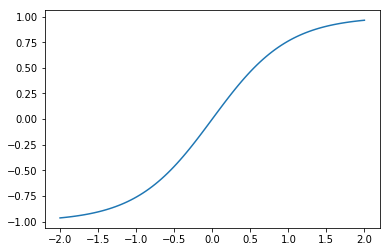

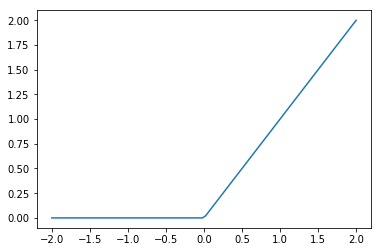

In [6]:
x = torch.linspace(-2,2,100)


tanh_1 = Tanh()
y_tan = tanh_1.forward(x)
plt.plot(x.numpy(), y_tan.numpy())
plt.show()

relu_1 = Relu()
y_relu = relu_1.forward(x)
grad = relu_1.backward(y_relu)
# print(grad)                          
plt.plot(x.numpy(), y_relu.numpy())
plt.show()




## Loss

In [7]:
class LossMSE():
    
    output = empty((0,0))
    target_output = empty((0,0))
    
    def forward( self , output, target_output ):
        self.output = output
        self.target_output = target_output
        loss = (output - target_output).pow(2).mean()  # (dim=0).sum()
        return loss
        #raise NotImplementedError

    def backward ( self ):
        return 2*(self.output - self.target_output)/self.output.numel()  # size(dim=0)

    def param ( self ) :
        return []

In [8]:
A = torch.tensor([[1.,1], [2,2]])
B = torch.zeros((2,2))

print((A - B).pow(2))
print((A - B).pow(2).mean(dim=0))
print((A - B).pow(2).mean(dim=0).sum())

print(A.size(dim=0))

tensor([[1., 1.],
        [4., 4.]])
tensor([2.5000, 2.5000])
tensor(5.)
2


## Linear

In [9]:
class Linear(): 
    
    x = empty((0,0))
    s = empty((0,0))
    gradwrtbias = empty((0,0))
    gradwrtweight = empty((0,0))
    
    def __init__(self, weight_size, bias_size):
        self.bias = empty(bias_size)
        self.weight = empty(weight_size)
        
    def normalize_parameters(self, mean, std):
        self.bias = self.bias.normal_(mean=mean, std=std)
        self.weight = self.weight.normal_(mean=mean, std=std)
        
    def define_parameters(self, weight, bias):
        self.weight = weight
        self.bias = bias.view((1, bias.numel()))
        
    
    def forward( self , *input ):
        x = input[0]
        self.x = x
        self.s = torch.mm(x, self.weight) + self.bias
        return self.s

    def backward( self , *gradwrtoutput ):
        gradwrtoutput = gradwrtoutput[0]
        self.gradwrtbias = torch.mm(torch.ones((1, self.x.size(dim=0))) ,gradwrtoutput)
        self.gradwrtweight = torch.mm(gradwrtoutput.t(), self.x)
        return torch.mm(gradwrtoutput, self.weight.t())
        
    def update_parameters(self, eta):
        raise NotImplementedError
        
    def param ( self ) :
        return [self.bias, self.weight]

In [10]:
A = torch.tensor([1.,2])
print(A.size())

torch.Size([2])


## Test

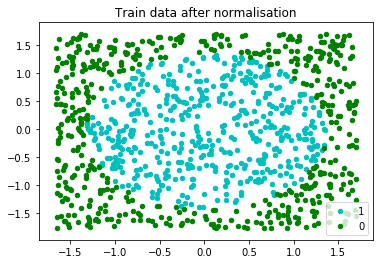

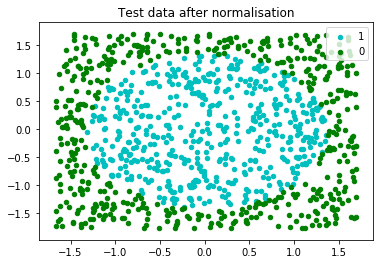

tensor([[ 1.1793, -0.8503],
        [ 0.3153,  0.9421],
        [ 0.6024,  0.5058],
        [ 0.5306,  1.2272],
        [-1.0473,  0.9816],
        [-0.0592,  0.4230],
        [-1.4040,  0.3358],
        [-0.2501,  1.6670],
        [-0.0754, -0.1190],
        [ 1.6996, -0.8886]])
tensor([[1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.]])


In [11]:
plt.scatter(train_input[(train_target[:,1]==1),0] ,train_input[(train_target[:,1]==1),1], color = "c", s=20)
plt.scatter(train_input[(train_target[:,1]==0),0] ,train_input[(train_target[:,1]==0),1], color = "g", s=20)
plt.title("Train data after normalisation")
plt.legend(["1", "0"] )
plt.show()

plt.scatter(test_input[(test_target[:,1]==1),0] ,test_input[(test_target[:,1]==1),1], color = "c", s=20)
plt.scatter(test_input[(test_target[:,1]==0),0] ,test_input[(test_target[:,1]==0),1], color = "g", s=20)
plt.title("Test data after normalisation")
plt.legend(["1", "0"] )
plt.show()


print(train_input[0:10,:])
print(train_target[0:10,:])

hidden_nb = 25

### With autograd

In [12]:
torch.set_grad_enabled(True)
train_input = Variable(train_input.data, requires_grad=True)

class Net(nn.Module):
    def __init__(self, hidden_neurons = 25):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, hidden_neurons)
        self.fc2 = nn.Linear(hidden_neurons, hidden_neurons)
        self.fc3 = nn.Linear(hidden_neurons, hidden_neurons)
        self.fc4 = nn.Linear(hidden_neurons, 2)

    def forward(self, x):
        x_0 = F.relu(self.fc1(x))
        x_1 = F.relu(self.fc2(x_0))
        x_2 = F.relu(self.fc3(x_1))
        x_3 = self.fc4(x_2)
        y = (x_0, x_1, x_2, x_3)
        return y

model, criterion = Net(), nn.MSELoss()

true_output = model(train_input)
true_loss = criterion(true_output[3], train_target)
print("Loss: ", true_loss.item())
#print(true_output[3][0:10,:])

model.zero_grad()
#true_loss.backward()
# print(model.fc1.bias)
print(torch.autograd.grad(true_loss, model.fc3.weight)[0])


torch.set_grad_enabled(False)


Loss:  0.46847689151763916
tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-1.4243e-03, -1.6584e-02, -6.0698e-03, -8.1618e-03, -7.9155e-03,
         -4.4362e-03, -3.6270e-03, -1.6673e-02, -1.3654e-02,  0.0000e+00,
         -1.1078e-02, -2.2683e-02, -5.1442e-03, -2.8735e-02, -2.7147e-02,
         -1.6911e-03, -2.4967e-02,  0.0000e+00,  0.0000e+00, -8.6277e-03,
         -3.0096e-03, -1.8923e-04, -9.8966e-04, -6.0224e-05, -1.9262e-03],
        [ 2.8749e-03,  1.4854e-02,  8.1610e-03,  1.1752e-02,  1.7886e-02,
          7.9262e-03,  5.4174e-03,  2.5675e-02,  2.2252e-02,  0.0000e+00,
          2.2255e-02,  3.0640e-02,  8.5185e-03,  3.8409e-02,  3.7409e-02,
         

### Without autograd

In [13]:




linear_1 = Linear(weight_size=(2,hidden_nb) , bias_size=(1,hidden_nb))
relu_1 = Relu()
linear_2 = Linear(weight_size=(hidden_nb,hidden_nb) , bias_size=(1,hidden_nb))
relu_2 = Relu()
linear_3 = Linear(weight_size=(hidden_nb,hidden_nb) , bias_size=(1,hidden_nb))
relu_3 = Relu()
linear_4 = Linear(weight_size=(hidden_nb,2) , bias_size=(1,2))
#relu_4 = Relu()
loss = LossMSE()

# linear_1.normalize_parameters(mean=1, std=2)
# linear_2.normalize_parameters(mean=1, std=2)
# linear_3.normalize_parameters(mean=1, std=2)
# linear_4.normalize_parameters(mean=1, std=2)

linear_1.define_parameters(model.fc1.weight.t(), model.fc1.bias)
linear_2.define_parameters(model.fc2.weight.t(), model.fc2.bias)
linear_3.define_parameters(model.fc3.weight.t(), model.fc3.bias)
linear_4.define_parameters(model.fc4.weight.t(), model.fc4.bias)



def model_forward(x, target_x):
    x = relu_1.forward(linear_1.forward(x))
    x = relu_2.forward(linear_2.forward(x))
    x = relu_3.forward(linear_3.forward(x))
    x = linear_4.forward(x)    #relu_4.forward(
    #print(x[0:4,:])
    l = loss.forward(x, target_x)
    print("loss: ", l.item(), "\n")
    return x  
    
our_output = model_forward(train_input, train_target)


## MODEL BACKWARD PASS
def model_backward():
    grad = loss.backward()
    #grad = relu_4.backward(grad)
    grad = linear_4.backward(grad)
    #print(grad.t())
    grad = relu_3.backward(grad)
    grad = linear_3.backward(grad)
    #print(grad.size())
    grad = relu_2.backward(grad)
    grad = linear_2.backward(grad)
    #print(grad.size())
    grad = relu_1.backward(grad)
    grad = linear_1.backward(grad)
    #print(grad.size())
    return(grad)

grad = model_backward()

#print(true_output[3][0:4,:])
print(linear_3.gradwrtweight)

loss:  0.46847689151763916 

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-1.4243e-03, -1.6584e-02, -6.0698e-03, -8.1618e-03, -7.9155e-03,
         -4.4362e-03, -3.6270e-03, -1.6673e-02, -1.3654e-02,  0.0000e+00,
         -1.1078e-02, -2.2683e-02, -5.1442e-03, -2.8735e-02, -2.7147e-02,
         -1.6911e-03, -2.4967e-02,  0.0000e+00,  0.0000e+00, -8.6277e-03,
         -3.0096e-03, -1.8923e-04, -9.8966e-04, -6.0224e-05, -1.9262e-03],
        [ 2.8749e-03,  1.4854e-02,  8.1610e-03,  1.1752e-02,  1.7886e-02,
          7.9262e-03,  5.4174e-03,  2.5675e-02,  2.2252e-02,  0.0000e+00,
          2.2255e-02,  3.0640e-02,  8.5185e-03,  3.8409e-02,  3.7409e-02,
       

In [14]:
print(true_output[3][0:3,:])
print(our_output[0:3,:])

tensor([[-0.0699,  0.2135],
        [-0.1088,  0.1744],
        [-0.1075,  0.1874]], requires_grad=True)
tensor([[-0.0699,  0.2135],
        [-0.1088,  0.1744],
        [-0.1075,  0.1874]])
